# Langgraph 2: Graph with Interrupt

In [3]:
#########  LangGraph  ##########################
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages

import panel as pn
from typing import TypedDict, Annotated, List, Sequence
from IPython.display import display, Markdown,Latex,Image

# Graph with interrupt

https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787

https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/

This code defines a simple graph-based flow using nodes, states, and transitions between them, with each node performing a specific task in sequence. Here's a breakdown of the code:

### 1. **State Definition**

   ```python
   class State(TypedDict):
       input: str
       messages: Annotated[list, add_messages]
   ```
   - `State` is a custom data structure using `TypedDict` to define the types of state properties.
   - It has two fields:
     - `input`: a string input, likely used for carrying initial data.
     - `messages`: a list of messages, annotated for additional behavior, presumably where the flow can accumulate or modify output messages as it progresses through nodes.

### 2. **Node Functions**

   - Each node function (`node1`, `node2`, `node3`) modifies the `state` and then returns it. Each function performs the following:

     - **`node1`**: Starts by printing "Start node1" and sets `state["messages"]` to `["Output node1: I wanna go home"]`.
     - **`node2`**: Starts by printing "Start node2" and sets `state["messages"]` to `["Output node2: What's the problem with node1?"]`.
     - **`node3`**: Starts by printing "Start node3" and sets `state["messages"]` to `["node3: I am going home"]`.

   - Each node is designed to sequentially alter `state["messages"]` with a unique message.

### 3. **StateGraph Creation**

   ```python
   builder = StateGraph(State)
   builder.add_node("node1", node1)
   builder.add_node("node2", node2)
   builder.add_node("node3", node3)
   builder.set_entry_point("node1")
   ```
   - `StateGraph` is initialized with the `State` structure, which defines the state format that each node will manipulate.
   - Nodes `node1`, `node2`, and `node3` are added to the graph with corresponding functions.
   - `set_entry_point("node1")` designates `node1` as the starting point of the graph.

### 4. **Defining the Flow (Edges)**

   ```python
   builder.add_edge("node1", "node2")
   builder.add_edge("node2", "node3")
   builder.add_edge("node3", END)
   ```
   - These edges define the sequence in which nodes execute:
     - After `node1`, the flow proceeds to `node2`.
     - After `node2`, it moves to `node3`.
     - After `node3`, the process ends (`END`).

### 5. **Memory Setup and Graph Compilation**

   ```python
   memory = MemorySaver()
   graph = builder.compile(checkpointer=memory, interrupt_before=["node3"])
   ```
   - `MemorySaver()` is set up to track the state across the nodes, storing each step in memory.
   - `interrupt_before=["node3"]` indicates an interruption before `node3` executes, perhaps to review or change the state.

### 6. **Visualization of the Graph**

   ```python
   display(Image(graph.get_graph().draw_mermaid_png()))
   ```
   - Finally, the code generates and displays a graphical representation of the flow using `Mermaid` notation. Each node and edge of the graph will be displayed, showing how the flow progresses from `node1` to `node2` to `node3`.

### Summary

This code builds a simple stateful flow where:
- **Each node** changes the `state["messages"]`.
- **Flow** goes from `node1` ➔ `node2` ➔ `node3`.
- **Memory and interruption** allow state tracking and intervention before the final node.
- **Graph visualization** shows the flow for easier comprehension and debugging. 

This setup can be particularly useful in chatbot flows, decision trees, or automated process orchestration scenarios where states change sequentially through nodes.

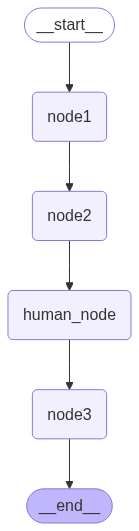

In [4]:
class State(TypedDict):
    input: str
    messages: Annotated[list, add_messages]


def node1(state:State):
    latest_message = state["messages"][-1] if state["messages"] else "No messages"
    print(f"Start node1 with latest message: {latest_message}")
    return {'messages' : "Here is some code" }


def node2(state:State):
    latest_message = state["messages"][-1] if state["messages"] else "No messages"
    print(f"Start node2 with latest message: {latest_message}")
    return {'messages' : "here is some more code" }


def node3(state:State):
    latest_message = state["messages"][-1] if state["messages"] else "No messages"
    print(f"Start node3 with latest message: {latest_message}")
    state["messages"]=["node3: I am going home"]
    return state 


builder = StateGraph(State)
builder.add_node("node1", node1)
builder.set_entry_point("node1")
builder.add_node("node2", node2)
builder.add_edge("node1", "node2")
from langgraph.types import interrupt, Command
def human_node(state: State):
    value = interrupt( 
        {
            "text_to_revise": state["messages"][-1] if state["messages"] else "No messages",
        }
    )
    return {
        "messages": "this is the human response" 
    }
builder.add_node("human_node", human_node)
builder.add_edge("node2", "human_node")
builder.add_node("node3", node3)
builder.add_edge("human_node", "node3")
builder.add_edge("node3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from logging_config.logger import LOG
from langgraph.types import Command, interrupt
thread = {"configurable": {"thread_id": "3"}}  
def input_function(question:str, thread : dict = thread):
    input = {"input": question}
    out=[]
    current_state = graph.get_state(thread).values
    LOG.info(f"Current state before invoking graph: {current_state}")
    graph.update_state(thread,current_state)
    response = graph.invoke(input, thread )
    if response["messages"]:
        out.append(response["messages"][-1].content)
    # for state in graph.stream(input, thread, stream_mode="values"):
    #     out.append(state["messages"][-1].content)  
    LOG.info(f'Response from input function: {response}')
    answer="Graph : "+ "\n".join(out)
    print("Input_function : \n",answer)
    print('------')
    return answer
def resume_function(human_response:str, thread: dict = thread):
    human_command = Command(update={"messages": human_response})
    response = graph.invoke(human_command, thread)
    out = []
    if response["messages"]:
        out.append(response["messages"][-1].content)
    # for state in graph.stream(human_command, thread, stream_mode="values"):
    #     out.append(state["messages"][-1].content)
    LOG.info(f'Response from resume function: {response}')
    answer = "Graph after resume: " + "\n".join(out)
    print("Resume_function : \n", answer)
    print('------')
    return answer
        
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
output = pn.pane.Markdown("Answer")  # This will display the answer text
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
output = pn.pane.Markdown("Answer")
answer_button = pn.widgets.Button(name="Answer", button_type="primary", width=50, height=50)



def button_click(event):
    print(f'number of clicks: {answer_button.clicks}')
    if answer_button.clicks == 1:
        bound_function = pn.bind(input_function, question)
        output.object = f"Answer:\n {bound_function()}"
    if answer_button.clicks > 1:
        bound_function = pn.bind(resume_function, question)
        output.object = f"Answer after resume:\n {bound_function()}"

answer_button.on_click(button_click)

Tab = pn.Column(
    pn.Row(question),
    pn.panel(answer_button, loading_indicator=True, height=50),
    pn.layout.Divider(),
    pn.panel(output, loading_indicator=True, height=900),
    sizing_mode="stretch_width"
)

layout = pn.Column(pn.Tabs(('Answer', Tab)))
layout.show()


Launching server at http://localhost:43719


number of clicks: 1
2025-07-13 13:27:33 INFO     debug [4028695748.py:8]: Current state before invoking graph: {}
Start node1 with latest message: No messages
Start node2 with latest message: content='Here is some code' additional_kwargs={} response_metadata={} id='cb807097-a0e9-442a-8ccf-d837950905d0'
2025-07-13 13:27:33 INFO     debug [4028695748.py:15]: Response from input function: {'input': 'yoo', 'messages': [HumanMessage(content='Here is some code', additional_kwargs={}, response_metadata={}, id='cb807097-a0e9-442a-8ccf-d837950905d0'), HumanMessage(content='here is some more code', additional_kwargs={}, response_metadata={}, id='58c3404c-3080-4c5f-a507-5900abd618a6')], '__interrupt__': [Interrupt(value={'text_to_revise': HumanMessage(content='here is some more code', additional_kwargs={}, response_metadata={}, id='58c3404c-3080-4c5f-a507-5900abd618a6')}, resumable=True, ns=['human_node:cde6343b-2252-cb73-d63d-6c9faa251708'])]}
Input_function : 
 Graph : here is some more code
--

In [11]:
graph.get_state(thread).values['messages']





[HumanMessage(content='Here is some code', additional_kwargs={}, response_metadata={}, id='39d722a0-d551-4c89-9f93-46c675f26e91'),
 HumanMessage(content='here is some more code', additional_kwargs={}, response_metadata={}, id='41f3af19-ad09-4b89-84ad-da5a052b5e9d')]